Stratified sampling makes sure that the distribution remains the same when you randomly split a training and testset
one condition is that the number of categries have a subtantial amount of data inside (otherwise it won't work), that is why we group media_income to smaller discrete groups ( 5 in total)
Afterwards the newly create income_cat category can be dropped


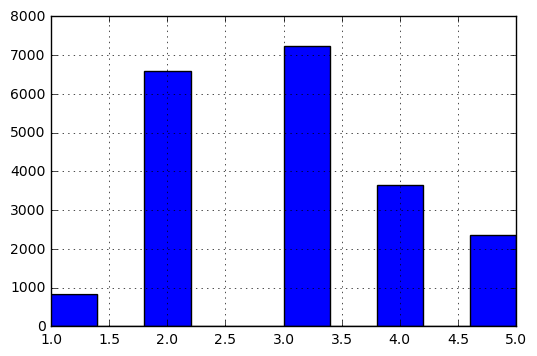

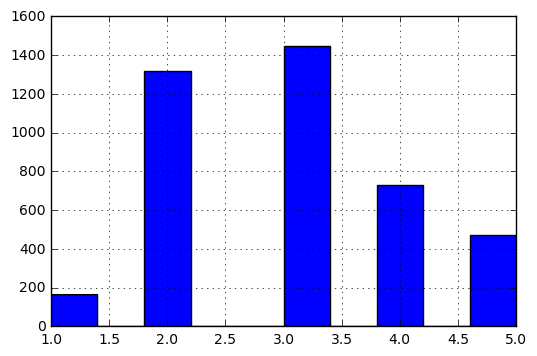

      overall   testset
1.0  0.039826  0.039729
2.0  0.318847  0.318798
3.0  0.350581  0.350533
4.0  0.176308  0.176357
5.0  0.114438  0.114583


In [2]:
import pandas as pd;
import matplotlib.pyplot as plt;
import numpy as np;
from sklearn.model_selection import StratifiedShuffleSplit;

houses=pd.read_csv("housing.csv");
houses["income_cat"]=np.ceil(houses["median_income"]/1.5);
houses["income_cat"].where(houses["income_cat"]<5,5.0,inplace=True);
houses["income_cat"].hist()
plt.show();

split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for traini, testi in split.split(houses,houses["income_cat"]):
    trainset=houses.loc[traini]
    testset=houses.loc[testi]

testset["income_cat"].hist()
plt.show()

vals=pd.DataFrame({"overall":houses["income_cat"].value_counts()/len(houses),
             "testset":testset["income_cat"].value_counts()/len(testset)})
print(vals.sort_index())
trainset.drop(["income_cat"],axis=1,inplace=True);
testset.drop(["income_cat"],axis=1,inplace=True);


It's easy to visualize the data

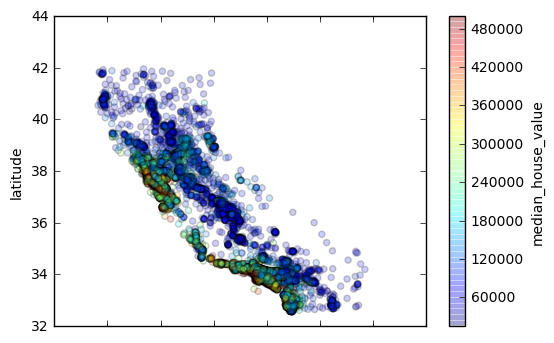

In [3]:
trainset.plot(kind="scatter",x="longitude",y="latitude",alpha=0.2,c="median_house_value",cmap=plt.get_cmap("jet"), colorbar=True)
plt.show()

In [42]:
correlations=trainset.corr()
correlations["median_house_value"].sort_values()

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

Median_income has high correlations to house value

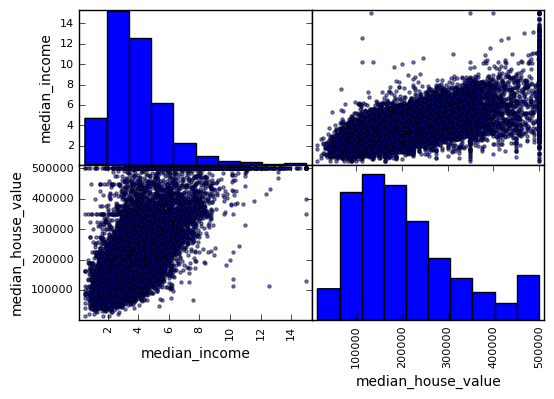

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(trainset[["median_income","median_house_value"]])
plt.show()

Imputer transformation can be used to fill in blanks with e.g. median

In [11]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
#trainset_num=trainset.drop("ocean_proximity",axis=1)
imputer.fit(trainset_num)
imputer.transform(trainset_num)

TypeError: transform() takes exactly 2 arguments (1 given)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [9]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(trainset_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


NameError: name 'trainset_num' is not defined